In [80]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table
import importlib
importlib.reload(utils.data_processing_bronze_table)
importlib.reload(utils.data_processing_silver_table)
importlib.reload(utils.data_processing_gold_table)


<module 'utils.data_processing_gold_table' from '/app/utils/data_processing_gold_table.py'>

## set up pyspark session

In [54]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## Build Bronze Table

In [55]:
# create bronze datalake
bronze_lms_directory = "datamart/bronze/lms/"
bronze_clickstream_directory = "datamart/bronze/clickstream/"
bronze_attr_directory = "datamart/bronze/attributes/"
bronze_fin_directory = "datamart/bronze/fin/"

for directory in [
    bronze_lms_directory,
    bronze_clickstream_directory,
    bronze_attr_directory,
    bronze_fin_directory
]:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory (if missing): {directory}")

Created directory (if missing): datamart/bronze/lms/
Created directory (if missing): datamart/bronze/clickstream/
Created directory (if missing): datamart/bronze/attributes/
Created directory (if missing): datamart/bronze/fin/


In [81]:
# inspect output
utils.data_processing_bronze_table.process_bronze_table("data/lms_loan_daily.csv",bronze_lms_directory, spark)
utils.data_processing_bronze_table.process_bronze_table("data/feature_clickstream.csv",bronze_clickstream_directory, spark)
utils.data_processing_bronze_table.process_bronze_table("data/features_attributes.csv",bronze_attr_directory, spark)
utils.data_processing_bronze_table.process_bronze_table("data/features_financials.csv",bronze_fin_directory, spark)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

## Build Silver Table

In [82]:
# create bronze datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"
silver_fin_directory = "datamart/silver/fin/"
silver_attr_directory = "datamart/silver/attributes/"

for directory in [
    silver_loan_daily_directory,
    silver_fin_directory,
    silver_attr_directory
]:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory (if missing): {directory}")

Created directory (if missing): datamart/silver/loan_daily/
Created directory (if missing): datamart/silver/fin/
Created directory (if missing): datamart/silver/attributes/


In [83]:
utils.data_processing_silver_table.process_silver_table_lms(bronze_lms_directory, silver_loan_daily_directory, spark)
utils.data_processing_silver_table.process_silver_table_attr(bronze_attr_directory, silver_attr_directory, spark)
utils.data_processing_silver_table.process_silver_table_fin(bronze_fin_directory, silver_fin_directory, spark)

[SILVER/LMS] Found 35 bronze LMS partitions...


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


[SILVER/LMS] Finished writing to datamart/silver/loan_daily/
[SILVER/ATTR] Found 25 bronze attribute partitions...
[SILVER/ATTR] Finished writing to datamart/silver/attributes/
[SILVER/FIN] Found 25 bronze FIN partitions...
[SILVER/FIN] Finished writing to datamart/silver/fin/


True

In [93]:
# --- Financial Table ---
print("=== Silver Financial Table ===")
df_fin = spark.read.parquet("datamart/silver/fin/silver_fin_2023_01_01.parquet")
df_fin.printSchema()
df_fin.show(5, truncate=False)

# --- Attribute Table ---
print("\n=== Silver Attribute Table ===")
df_attr = spark.read.parquet("datamart/silver/attributes/silver_attr_2023_01_01.parquet")
df_attr.printSchema()
df_attr.show(5, truncate=False)

# --- Loan Daily Table ---
print("\n=== Silver Loan Daily Table ===")
df_lms = spark.read.parquet("datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet")
df_lms.printSchema()
df_lms.show(5, truncate=False)


=== Silver Financial Table ===
root
 |-- Customer_ID: string (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Monthly_Inhand_Salary: float (nullable = true)
 |-- Num_Bank_Accounts: float (nullable = true)
 |-- Num_Credit_Card: float (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Num_of_Loan: float (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: float (nullable = true)
 |-- Num_of_Delayed_Payment: float (nullable = true)
 |-- Changed_Credit_Limit: float (nullable = true)
 |-- Num_Credit_Inquiries: float (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- Credit_Utilization_Ratio: float (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: float (nullable = true)
 |-- Amount_invested_monthly: float (nullable = true)
 |-- Payment_Behaviour: string (nullable = true)
 |-- Monthly_Balance: float (nullable = true)


## EDA on credit labels

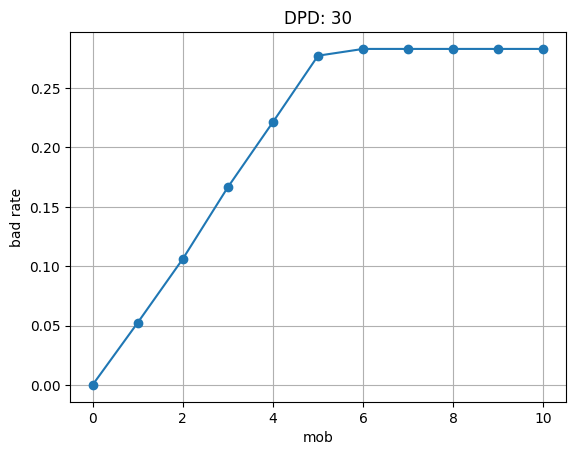

In [97]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [12]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

## Build gold table for labels

In [13]:
# create bronze datalake
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [14]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)


loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet row count: 530
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet row count: 1031
saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet row count: 1537
saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_04_01.parquet row count: 2047
saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet row count: 2568
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet row count: 3085
saved to: datamart/gold/label_store/gold_label_store_2023_06_01.parquet
loaded from

In [15]:
utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6).dtypes


loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

## inspect label store

In [16]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [17]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)

